# Python Code to plot the loop gain results from Middlebrook's method and Tian's method

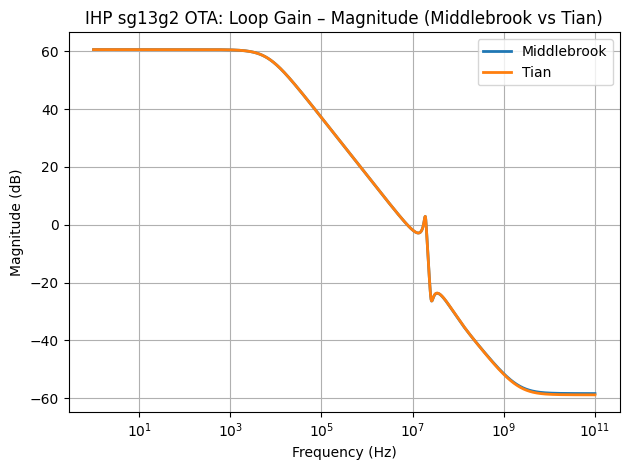

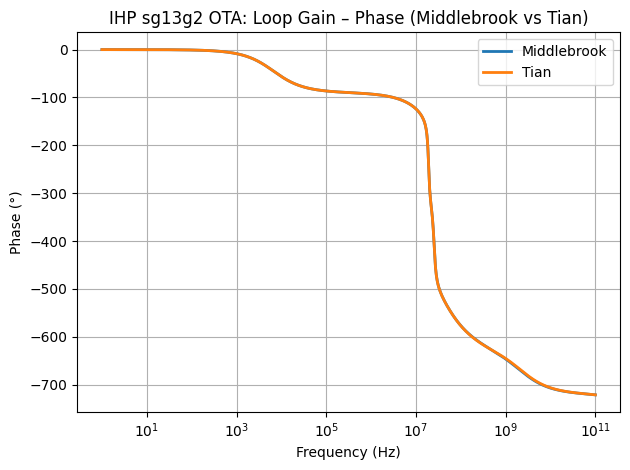

In [12]:
from PyLTSpice.LTSpice_RawRead import RawRead
import matplotlib.pyplot as plt
import numpy as np

# Directory to save SVGs
output_dir = "../Designs/otas/1_schematics/simulations"

# --------------------------------------------------------------------
# 1. Read loop-gain raw file
# --------------------------------------------------------------------
LTR = RawRead(f"{output_dir}/foldedcascode_nmos_tb-loopgain.raw")

# print(LTR.get_trace_names())
# print("\n")
# print(LTR.get_raw_property())
# print("\n")

steps = LTR.get_steps()
num_steps = len(steps)
# print("number of sweeps in the simulation:", num_steps)

# --------------------------------------------------------------------
# 2. Get frequency axis + loop-gain vectors (Middlebrook & Tian)
# --------------------------------------------------------------------
# Your .control sequence is: op, ac, write, appendwrite.
# For the AC analysis, the x-axis in PyLTSpice is the frequency vector.

if num_steps == 1:
    freq = LTR.get_axis(0)  # frequency in Hz

    # These names come directly from your .control block:
    #   let tmb   = ...
    #   let ttian = ...
    tmb_trace   = LTR.get_trace("tmb")
    ttian_trace = LTR.get_trace("ttian")

    tmb   = tmb_trace.get_wave(0)   # complex loop gain (Middlebrook)
    ttian = ttian_trace.get_wave(0) # complex loop gain (Tian)
else:
    # If there are multiple sweeps/analyses, pick the AC one by index.
    # Usually step 0 is AC if you did 'op' + 'ac' then write.
    step_index = 0
    freq = LTR.get_axis(step_index)
    tmb   = LTR.get_trace("tmb").get_wave(step_index)
    ttian = LTR.get_trace("ttian").get_wave(step_index)

# --------------------------------------------------------------------
# 3. Convert to magnitude (dB) and phase (deg)
# --------------------------------------------------------------------
# Even though you used db(tmb) and cphase(tmb) in ngspice plots,
# those were just for the ngspice GUI. Here we recompute cleanly.

mag_tmb   = 20 * np.log10(np.abs(tmb))
mag_ttian = 20 * np.log10(np.abs(ttian))

phase_tmb   = np.angle(tmb, deg=True)
phase_ttian = np.angle(ttian, deg=True)

# Optional: unwrap phase for a smooth curve
phase_tmb   = np.unwrap(np.deg2rad(phase_tmb)) * 180 / np.pi
phase_ttian = np.unwrap(np.deg2rad(phase_ttian)) * 180 / np.pi

# --------------------------------------------------------------------
# 4. Bode magnitude: Middlebrook vs Tian
# --------------------------------------------------------------------
fig_mag = plt.figure()

plt.title("IHP sg13g2 OTA: Loop Gain – Magnitude (Middlebrook vs Tian)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")

plt.semilogx(freq, mag_tmb,   label="Middlebrook", linewidth=2.0)
plt.semilogx(freq, mag_ttian, label="Tian",        linewidth=2.0)

plt.grid(True, which="both", axis="both")
plt.legend(loc="best", frameon=True, fontsize=10)

fig_mag.tight_layout()
plt.savefig(f"{output_dir}/_fig_loopgain_magnitude.svg", format="svg")
plt.show()

# --------------------------------------------------------------------
# 5. Bode phase: Middlebrook vs Tian
# --------------------------------------------------------------------
fig_phase = plt.figure()

plt.title("IHP sg13g2 OTA: Loop Gain – Phase (Middlebrook vs Tian)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase (°)")

plt.semilogx(freq, phase_tmb,   label="Middlebrook", linewidth=2.0)
plt.semilogx(freq, phase_ttian, label="Tian",        linewidth=2.0)

plt.grid(True, which="both", axis="both")
plt.legend(loc="best", frameon=True, fontsize=10)

fig_phase.tight_layout()
plt.savefig(f"{output_dir}/_fig_loopgain_phase.svg", format="svg")
plt.show()


# Python code to plot the ac analysis

DC gain (linear)  = 1.0076
3dB bandwidth     = 1.02e+07+0.00e+00j Hz
Gain error vs 1   = 7.5572e-03


C:\Users\HP\AppData\Local\Temp\ipykernel_16744\642713836.py:95: ComplexWarning: Casting complex values to real discards the imaginary part
  r"fbw = %.2e Hz" % fbw,


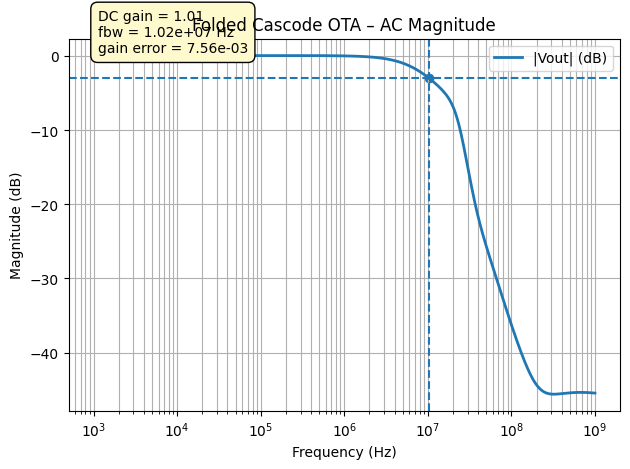

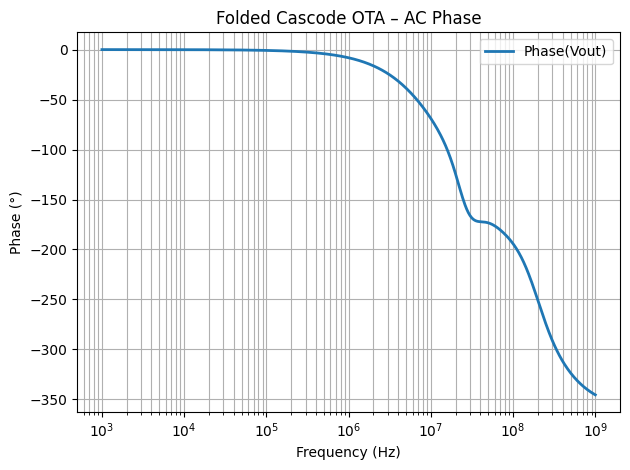

C:\Users\HP\AppData\Local\Temp\ipykernel_16744\642713836.py:154: ComplexWarning: Casting complex values to real discards the imaginary part
  r"fbw = %.2e Hz" % fbw,


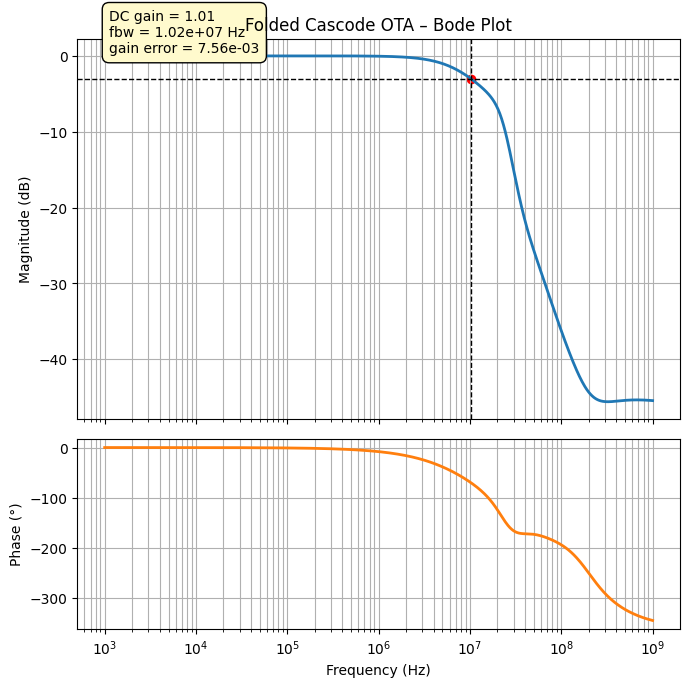

In [15]:
# foldedcascode_ac_sim.py

from PyLTSpice.LTSpice_RawRead import RawRead
import matplotlib.pyplot as plt
import numpy as np

# Directory and raw file (adapt as needed)
output_dir = "../Designs/otas/1_schematics/simulations"
raw_path = f"{output_dir}/tb_foldedcascode_nmos_ac.raw"

# --------------------------------------------------------------------
# 1. Read raw file
# --------------------------------------------------------------------
LTR = RawRead(raw_path)

# print(LTR.get_trace_names())
# print("\n")
# print(LTR.get_raw_property())
# print("\n")

steps = LTR.get_steps()
num_steps = len(steps)
# print("number of sweeps in the simulation:", num_steps)

# --------------------------------------------------------------------
# 2. Get AC frequency axis and output vector
# --------------------------------------------------------------------
# If you have both AC and NOISE in the same file, step 0 is usually AC.
# v(v_out) vs v_out: check print(get_trace_names()) and adjust the name.

ac_step_index = 0

freq = LTR.get_axis(ac_step_index)  # frequency in Hz

# Try both common naming variants:
trace_names = LTR.get_trace_names()
if "v(v_out)" in trace_names:
    vout_trace_name = "v(v_out)"
elif "v_out" in trace_names:
    vout_trace_name = "v_out"
else:
    raise RuntimeError("Could not find v_out trace. Check LTR.get_trace_names().")

Vout_trace = LTR.get_trace(vout_trace_name)
Vout = Vout_trace.get_wave(ac_step_index)  # complex AC voltage

# --------------------------------------------------------------------
# 3. Compute magnitude/phase and DC gain, 3dB BW, gain error
# --------------------------------------------------------------------
# Assuming Vin AC magnitude = 1, |Vout| = gain (linear).

vmag = np.abs(Vout)                      # linear gain
mag_db = 20 * np.log10(vmag)             # dB
phase_deg = np.angle(Vout, deg=True)
phase_deg = np.unwrap(np.deg2rad(phase_deg)) * 180 / np.pi

# DC gain (same definition as your ngspice meas):
#   meas ac dcgain MAX vmag(v_out) FROM=10 TO=10k
mask_dc = (freq >= 10) & (freq <= 10e3)
dcgain = np.max(vmag[mask_dc])
# dcgain_db = 20 * np.log10(dcgain)

# 3dB bandwidth:
#   f3db = dcgain/sqrt(2)
f3db_mag = dcgain / np.sqrt(2)

# Find first frequency where |Vout| falls below f3db_mag
idx_bw_candidates = np.where(vmag <= f3db_mag)[0]
if len(idx_bw_candidates) > 0:
    fbw_idx = idx_bw_candidates[0]
    fbw = freq[fbw_idx]
else:
    fbw = np.nan  # in case it never drops

gainerror = (dcgain - 1.0) / 1.0

print(f"DC gain (linear)  = {dcgain:.4f}")
# print(f"DC gain (dB)      = {dcgain_db:.2f} dB")
print(f"3dB bandwidth     = {fbw:.2e} Hz")
print(f"Gain error vs 1   = {gainerror:.4e}")

# --------------------------------------------------------------------
# 4. Magnitude Bode plot
# --------------------------------------------------------------------
fig_mag = plt.figure()

plt.title("Folded Cascode OTA – AC Magnitude")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.semilogx(freq, mag_db, linewidth=2.0, label="|Vout| (dB)")

# Annotate DC gain and 3dB BW if available
text_lines = [
    r"DC gain = %.2f " % dcgain,
    r"fbw = %.2e Hz" % fbw,
    r"gain error = %.2e" % gainerror,
]
plt.annotate(
    "\n".join(text_lines),
    xy=(freq[5], mag_db[5]),
    xycoords="data",
    ha="left",
    va="bottom",
    fontsize=10,
    bbox=dict(facecolor="lemonchiffon", edgecolor="black", boxstyle="round,pad=0.5"),
)

# Mark the 3dB point on curve if valid
if not np.isnan(fbw):
    plt.axhline(20 * np.log10(f3db_mag), linestyle="--")
    plt.axvline(fbw, linestyle="--")
    plt.scatter([fbw], [20 * np.log10(f3db_mag)])

plt.grid(True, which="both", axis="both")
plt.legend(loc="best", frameon=True, fontsize=10)

fig_mag.tight_layout()
plt.savefig(f"{output_dir}/_fig_foldedcascode_ac_magnitude.svg", format="svg")
plt.show()

# --------------------------------------------------------------------
# 5. Phase Bode plot
# --------------------------------------------------------------------
fig_phase = plt.figure()

plt.title("Folded Cascode OTA – AC Phase")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase (°)")
plt.semilogx(freq, phase_deg, linewidth=2.0, label="Phase(Vout)")

plt.grid(True, which="both", axis="both")
plt.legend(loc="best", frameon=True, fontsize=10)

fig_phase.tight_layout()
plt.savefig(f"{output_dir}/_fig_foldedcascode_ac_phase.svg", format="svg")
plt.show()

# --------------------------------------------------------------------
# 6. Combined Bode Plot (Magnitude + Phase)
# --------------------------------------------------------------------
fig_bode, (ax_mag, ax_phase) = plt.subplots(
    2, 1, figsize=(7, 7), sharex=True, gridspec_kw={'height_ratios': [2, 1]}
)

# ----- Magnitude -----
ax_mag.semilogx(freq, mag_db, linewidth=2.0, color='tab:blue')
ax_mag.set_title("Folded Cascode OTA – Bode Plot")
ax_mag.set_ylabel("Magnitude (dB)")
ax_mag.grid(True, which="both", axis="both")

# Annotate DC gain, bandwidth, error
annot_lines = [
    r"DC gain = %.2f " % dcgain,
    r"fbw = %.2e Hz" % fbw,
    r"gain error = %.2e" % gainerror,
]
ax_mag.annotate(
    "\n".join(annot_lines),
    xy=(freq[5], mag_db[5]),
    xycoords="data",
    ha="left",
    va="bottom",
    fontsize=10,
    bbox=dict(facecolor="lemonchiffon", edgecolor="black", boxstyle="round,pad=0.5"),
)

# Mark 3dB point
if not np.isnan(fbw):
    ax_mag.axhline(20 * np.log10(f3db_mag), linestyle="--", color="black", linewidth=1)
    ax_mag.axvline(fbw, linestyle="--", color="black", linewidth=1)
    ax_mag.scatter([fbw], [20 * np.log10(f3db_mag)], color="red")

# ----- Phase -----
ax_phase.semilogx(freq, phase_deg, linewidth=2.0, color='tab:orange')
ax_phase.set_xlabel("Frequency (Hz)")
ax_phase.set_ylabel("Phase (°)")
ax_phase.grid(True, which="both", axis="both")

# ----- Layout -----
plt.tight_layout()
plt.savefig(f"{output_dir}/_fig_foldedcascode_ac_bode.svg", format="svg")
plt.show()



# Python code to plot the transient analysis


TRACE NAMES:
tstart  = 1.052 µs
tcross  = 1.245 µs
tsettle = 192.038 ns


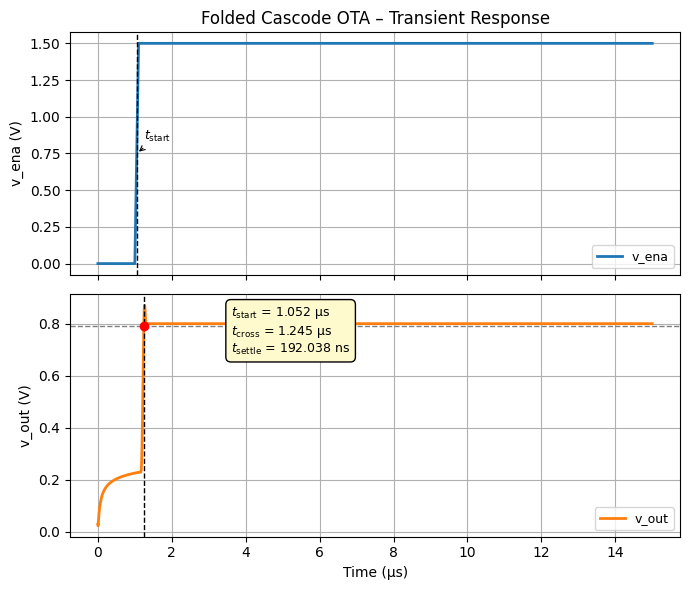

In [16]:
from PyLTSpice.LTSpice_RawRead import RawRead
import matplotlib.pyplot as plt
import numpy as np

# Paths
output_dir = "../Designs/otas/1_schematics/simulations"
raw_path = f"{output_dir}/tb_foldedcascode_nmos_tran.raw"

# --------------------------------------------------------------------
# 1. Read transient raw file
# --------------------------------------------------------------------
LTR = RawRead(raw_path)

print("TRACE NAMES:")
trace_names = LTR.get_trace_names()
# for name in trace_names:
#     print("  ", name)
# print("\n")
# print(LTR.get_raw_property())
# print("\n")

steps = LTR.get_steps()
num_steps = len(steps)
# print("number of sweeps in the simulation:", num_steps)

# --------------------------------------------------------------------
# 2. Get time axis and relevant node voltages
# --------------------------------------------------------------------
# For transient: 'time' trace and node voltages.
# ngspice usually uses names like 'v(v_ena)', 'v(v_out)'.

step_index = 0

time_trace = LTR.get_trace("time")
time = time_trace.get_time_axis(step_index)   # seconds

# Adjust names below if print(trace_names) shows slightly different ones
v_ena_trace = LTR.get_trace("v(v_ena)")
v_out_trace = LTR.get_trace("v(v_out)")

v_ena = v_ena_trace.get_wave(step_index)
v_out = v_out_trace.get_wave(step_index)

# --------------------------------------------------------------------
# 3. Recompute tstart, tcross, tsettle (like ngspice)
# --------------------------------------------------------------------
# From your .control:
#   let vout_limit=0.8*0.99
#   let vena_limit=0.5*1.5
#   tsettle = tcross - tstart

vout_limit = 0.8 * 0.99
vena_limit = 0.5 * 1.5

# First time v_out crosses vout_limit
idx_tcross = np.where(v_out >= vout_limit)[0]
if len(idx_tcross) > 0:
    tcross = time[idx_tcross[0]]
else:
    tcross = np.nan

# First time v_ena crosses vena_limit
idx_tstart = np.where(v_ena >= vena_limit)[0]
if len(idx_tstart) > 0:
    tstart = time[idx_tstart[0]]
else:
    tstart = np.nan

if not (np.isnan(tstart) or np.isnan(tcross)):
    tsettle = tcross - tstart
else:
    tsettle = np.nan

print(f"tstart  = {tstart*1e6:.3f} µs")
print(f"tcross  = {tcross*1e6:.3f} µs")
print(f"tsettle = {tsettle*1e9:.3f} ns")

# --------------------------------------------------------------------
# 4. Combined transient plot (like a bode-style figure)
# --------------------------------------------------------------------
# Time in microseconds for nicer axis units
time_us = time * 1e6

fig, (ax_ena, ax_out) = plt.subplots(
    2, 1, figsize=(7, 6), sharex=True, gridspec_kw={"height_ratios": [1, 1]}
)

# ----- Top: v_ena(t) -----
ax_ena.plot(time_us, v_ena, label="v_ena", linewidth=2.0)
ax_ena.set_title("Folded Cascode OTA – Transient Response")
ax_ena.set_ylabel("v_ena (V)")
ax_ena.grid(True, which="both", axis="both")
ax_ena.legend(loc="best", frameon=True, fontsize=9)

# Mark tstart on v_ena if valid
if not np.isnan(tstart):
    ax_ena.axvline(tstart * 1e6, linestyle="--", color="black", linewidth=1)
    ax_ena.annotate(
        r"$t_{\mathrm{start}}$",
        xy=(tstart * 1e6, vena_limit),
        xycoords="data",
        xytext=(5, 10),
        textcoords="offset points",
        fontsize=9,
        arrowprops=dict(arrowstyle="->", linewidth=0.8),
    )

# ----- Bottom: v_out(t) -----
ax_out.plot(time_us, v_out, label="v_out", linewidth=2.0, color="tab:orange")
ax_out.set_xlabel("Time (µs)")
ax_out.set_ylabel("v_out (V)")
ax_out.grid(True, which="both", axis="both")
ax_out.legend(loc="best", frameon=True, fontsize=9)

# Mark tcross and tsettle on v_out
annot_lines = []
if not np.isnan(tstart):
    annot_lines.append(r"$t_{\mathrm{start}}$ = %.3f µs" % (tstart * 1e6))
if not np.isnan(tcross):
    annot_lines.append(r"$t_{\mathrm{cross}}$ = %.3f µs" % (tcross * 1e6))
if not np.isnan(tsettle):
    annot_lines.append(r"$t_{\mathrm{settle}}$ = %.3f ns" % (tsettle * 1e9))

if annot_lines:
    ax_out.annotate(
        "\n".join(annot_lines),
        xy=(time_us[len(time_us)//4], v_out.max()),
        xycoords="data",
        ha="left",
        va="top",
        fontsize=9,
        bbox=dict(facecolor="lemonchiffon", edgecolor="black", boxstyle="round,pad=0.4"),
    )

if not np.isnan(tcross):
    ax_out.axvline(tcross * 1e6, linestyle="--", color="black", linewidth=1)
    ax_out.axhline(vout_limit, linestyle="--", color="gray", linewidth=1)
    ax_out.scatter([tcross * 1e6], [vout_limit], color="red", zorder=3)

plt.tight_layout()
plt.savefig(f"{output_dir}/_fig_foldedcascode_tran_combined.svg", format="svg")
plt.show()
